In [2]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from scipy.ndimage import binary_closing, binary_opening
import torchvision.transforms as transforms
from typing import Tuple

In [30]:
torch.cuda.get_device_name(0)

'NVIDIA A40'

In [6]:
def initialize_sam2(device):
    sam2_checkpoint = "../third_party/segment-anything-2/checkpoints/sam2_hiera_base_plus.pt"
    model_cfg = "sam2_hiera_b+.yaml"
    sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

    mask_predictor = SAM2AutomaticMaskGenerator(sam2)
    prompted_predictor = SAM2ImagePredictor(sam2)
    return sam2, mask_predictor, prompted_predictor

def generate_masks(mask_generator, prompted_predictor, image_path, point_prompt=None, box_prompt=None):
    """
    point_prompt: np.array(n,2), where n is # of points
    box_prompt: np.array(n,4), where n is # of boxes
    """
    image = Image.open(image_path)
    image = np.array(image.convert("RGB"))
    if point_prompt is None and box_prompt is None:
        masks = mask_generator.generate(image)
        valid_indices = deduplicate_masks(masks)
        return [masks[i] for i in range(len(masks)) if i in valid_indices]
    else:
        prompted_predictor.set_image(image)
        masks, scores, logits = prompted_predictor.predict(
            point_coords=point_prompt,
            box=box_prompt,
            multimask_output=True,
            point_labels=np.array([1]*len(point_prompt)),
        )
        return masks, scores, logits

def deduplicate_masks(masks, threshold=0.7):
    valid = set(list(range(len(masks))))
    for i in range(len(masks)):
        for j in range(i+1, len(masks)):
            mask1, mask2 = masks[i]['segmentation'], masks[j]['segmentation']
            iou = (mask1*mask2).sum()/(mask1+mask2).sum()
            if iou >= threshold:
                valid.remove(j)
    return valid
    
def create_mask_images(original_image, masks):
    original_image_array = np.array(original_image)
    all_cropped_imgs = []

    for i in range(masks.shape[0]):
        mask = masks[i, :, :]
        if isinstance(mask, np.ndarray):
            mask = torch.from_numpy(mask)
        np_mask = mask.unsqueeze(dim=2).numpy()
        masked_img = (original_image_array * np_mask).astype(np.uint8)  # Convert to uint8
        ys, xs = np.where(mask)
        if ys.size == 0 or xs.size == 0:
            continue
        bbox = np.min(xs), np.min(ys), np.max(xs), np.max(ys)
        cropped_image_array = masked_img[bbox[1]:bbox[3]+1, bbox[0]:bbox[2]+1, :]
        cropped_image_pil = Image.fromarray(cropped_image_array)
        all_cropped_imgs.append(cropped_image_pil)

    return all_cropped_imgs

def initialize_dinov2(device, REPO_NAME = "facebookresearch/dinov2", MODEL_NAME = "dinov2_vitb14"):
    model = torch.hub.load(repo_or_dir=REPO_NAME, model=MODEL_NAME)
    model.to(device)
    model.eval()
    return model

In [10]:
sam2, mask_predictor, prompted_predictor = initialize_sam2("cuda")
dinov2 = initialize_dinov2("cuda:0")

Using cache found in /nethome/abati7/.cache/torch/hub/facebookresearch_dinov2_main


In [ ]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=3) 

    ax.imshow(img)

image_path = "images/query_img.jpg"
image = Image.open(image_path)
image = np.array(image.convert("RGB"))
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [11]:
import urllib
import io

def load_array_from_url(url: str) -> np.ndarray:
    with urllib.request.urlopen(url) as f:
        array_data = f.read()
        g = io.BytesIO(array_data)
        return np.load(g)

DEFAULT_SMALLER_EDGE_SIZE = 448
DEFAULT_BACKGROUND_THRESHOLD = 0.05
DEFAULT_APPLY_OPENING = False
DEFAULT_APPLY_CLOSING = False
STANDARD_ARRAY_URL = "https://dl.fbaipublicfiles.com/dinov2/arrays/standard.npy"
standard_array = load_array_from_url(STANDARD_ARRAY_URL)

In [27]:
def make_transform(smaller_edge_size: int) -> transforms.Compose:
    IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
    IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
    interpolation_mode = transforms.InterpolationMode.BICUBIC

    return transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=interpolation_mode, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ])

def prepare_image(image: Image,
                  smaller_edge_size: float,
                  patch_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    transform = make_transform(int(smaller_edge_size))
    image_tensor = transform(image)

    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % patch_size, height - height % patch_size
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // patch_size, cropped_width // patch_size) # h x w (TODO: check)
    scale_width = image.width / cropped_width
    scale_height = image.height / cropped_height
    return image_tensor, grid_size, (scale_width, scale_height)

def make_foreground_mask(tokens,
                         grid_size: Tuple[int, int],
                         background_threshold: float = 0.0,
                         apply_opening: bool = True,
                         apply_closing: bool = True):
    projection = tokens @ standard_array
    mask = projection > background_threshold
    mask = mask.reshape(*grid_size)
    if apply_opening:
        mask = binary_opening(mask)
    if apply_closing:
        mask = binary_closing(mask)
    return mask.flatten()

def render_patch_pca(model,
                     image: Image,
                     smaller_edge_size: float = 448,
                     patch_size: int = 14,
                     background_threshold: float = 0.05,
                     apply_opening: bool = False,
                     apply_closing: bool = False) -> Image:
    image_tensor, grid_size, _ = prepare_image(image, smaller_edge_size, patch_size)

    with torch.inference_mode():
        image_batch = image_tensor.unsqueeze(0)
        tokens = model.get_intermediate_layers(image_batch)[0].squeeze()

    # mask = make_foreground_mask(tokens,
    #                             grid_size,
    #                             background_threshold,
    #                             apply_opening,
    #                             apply_closing)

    pca = PCA(n_components=3)
    pca.fit(tokens) #tokens[mask]
    projected_tokens = pca.transform(tokens)

    t = torch.tensor(projected_tokens)
    t_min = t.min(dim=0, keepdim=True).values
    t_max = t.max(dim=0, keepdim=True).values
    normalized_t = (t - t_min) / (t_max - t_min)

    array = (normalized_t * 255).byte().numpy()
    # array[~mask] = 0
    array = array.reshape(*grid_size, 3)

    return Image.fromarray(array).resize((image.width, image.height), 0)


def calculate_simmatrix(a, b, eps=1e-8):
    """
    a: NxD
    b: MxD
    
    out: NxM, each row contains how similar N_i is to each M
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = a_norm @ b_norm.T
    return sim_mt
    
def get_obj_embeddings(model, cropped_obj):
    """
    model - dinov2 model
    cropped_obj: Image
    """

    image_tensor, grid_size, scales = prepare_image(cropped_obj, 448, 14)
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    tokens, cls = model.get_intermediate_layers(image_tensor.unsqueeze(0).to(device), return_class_token=True)[0]
    return tokens.detach().cpu().squeeze(), cls.detach().cpu().squeeze(), (grid_size, scales)

def match_ref_and_query(query_embeddings, reference_embeddings):
    """
    query_embedding: NxD
    returns closest reference_embedding match to each query_embedding

    """
    similarities = calculate_simmatrix(query_embeddings, reference_embeddings)
    matched_ref_masks_idx = torch.argmax(similarities, dim=1)
    # self.matched_query_masks = self.query_masks[matched_query_masks_idx, :, :]
    # self.matched_query_patch_embeddings = self.query_patch_embeddings[matched_query_masks_idx, :, :]
    return matched_ref_masks_idx

In [14]:
image_path = "images/query_img.jpg"
image = Image.open(image_path)
render_patch_pca(dinov2,
                 image=image,
                 smaller_edge_size=DEFAULT_SMALLER_EDGE_SIZE,
                 patch_size=dinov2.patch_size,
                 background_threshold=DEFAULT_BACKGROUND_THRESHOLD,
                 apply_opening=DEFAULT_APPLY_OPENING,
                 apply_closing=DEFAULT_APPLY_CLOSING)

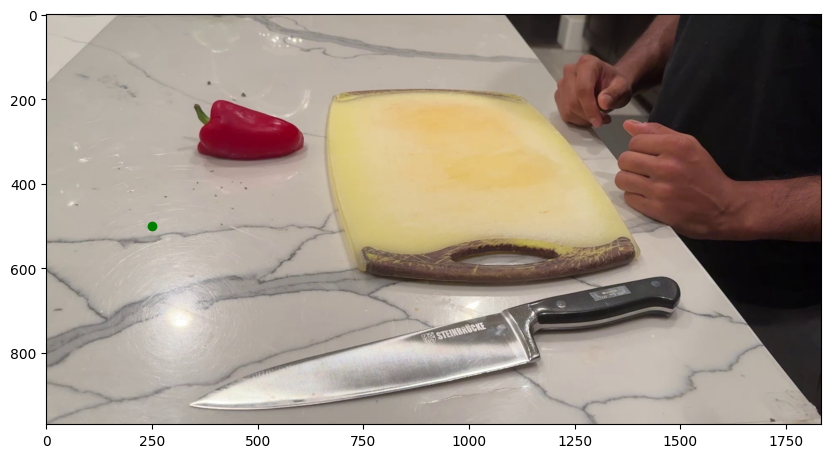

In [72]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
pos_points = np.array([[250,500]])
plt.gca().scatter(pos_points[:, 0], pos_points[:, 1], color='green')
plt.axis('on')
plt.show()

In [39]:
image_path1 = "images/query_img.jpg"
image1 = Image.open(image_path1)
pos_points = np.array([[475,280]])

image_path2 = "images/current_vid_0.jpg"
image2 = Image.open(image_path2)


masks1, scores, logits = generate_masks(mask_predictor, prompted_predictor, image_path1, point_prompt=pos_points) #point prompt
best_mask1 = masks1[[np.argmax(scores)]]
# masks1 = generate_masks(mask_predictor, prompted_predictor, image_path1)
masks2 = generate_masks(mask_predictor, prompted_predictor, image_path2)

# cropped_images1 = create_mask_images(image1, np.array([mask['segmentation'] for mask in masks1]))
cropped_images1 = create_mask_images(image1, best_mask1)
cropped_images2 = create_mask_images(image2, np.array([mask['segmentation'] for mask in masks2]))


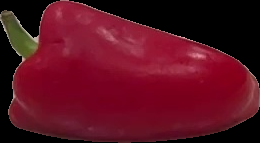

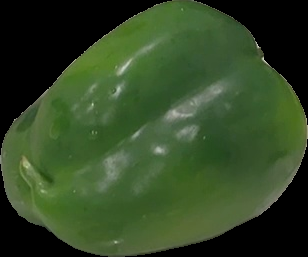

In [49]:
# query_idx = 5
query_cls = get_obj_embeddings(dinov2, cropped_images1[0])[1].unsqueeze(0) #get embedding for touched mask in image1; 1,768
refs_cls = torch.stack([get_obj_embeddings(dinov2, c)[1] for c in cropped_images2]) #get embeddings for each mask in reference; Nx768
idxs = match_ref_and_query(query_cls, refs_cls) # for each query, match to 1 reference
display(cropped_images1[0])
display(cropped_images2[idxs[0].item()])

In [ ]:
for im in cropped_images1:
    display(im)

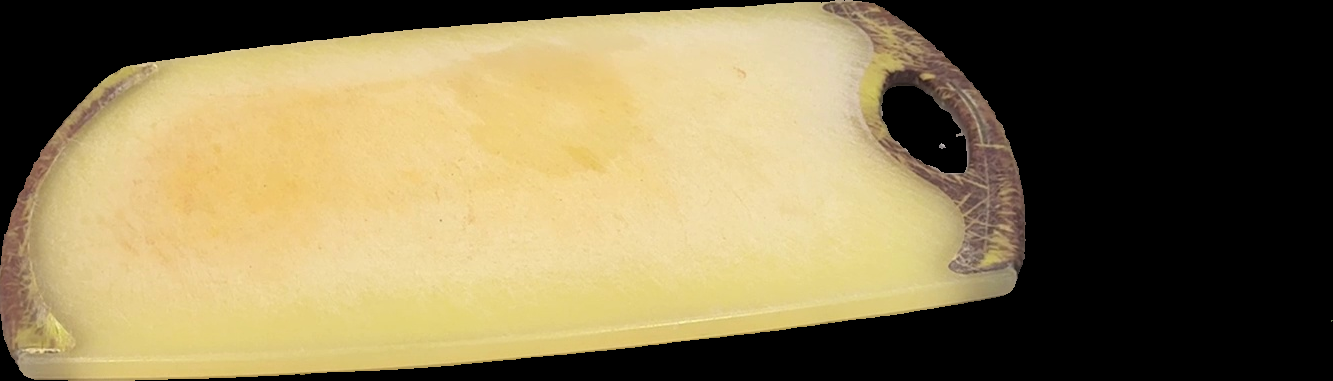

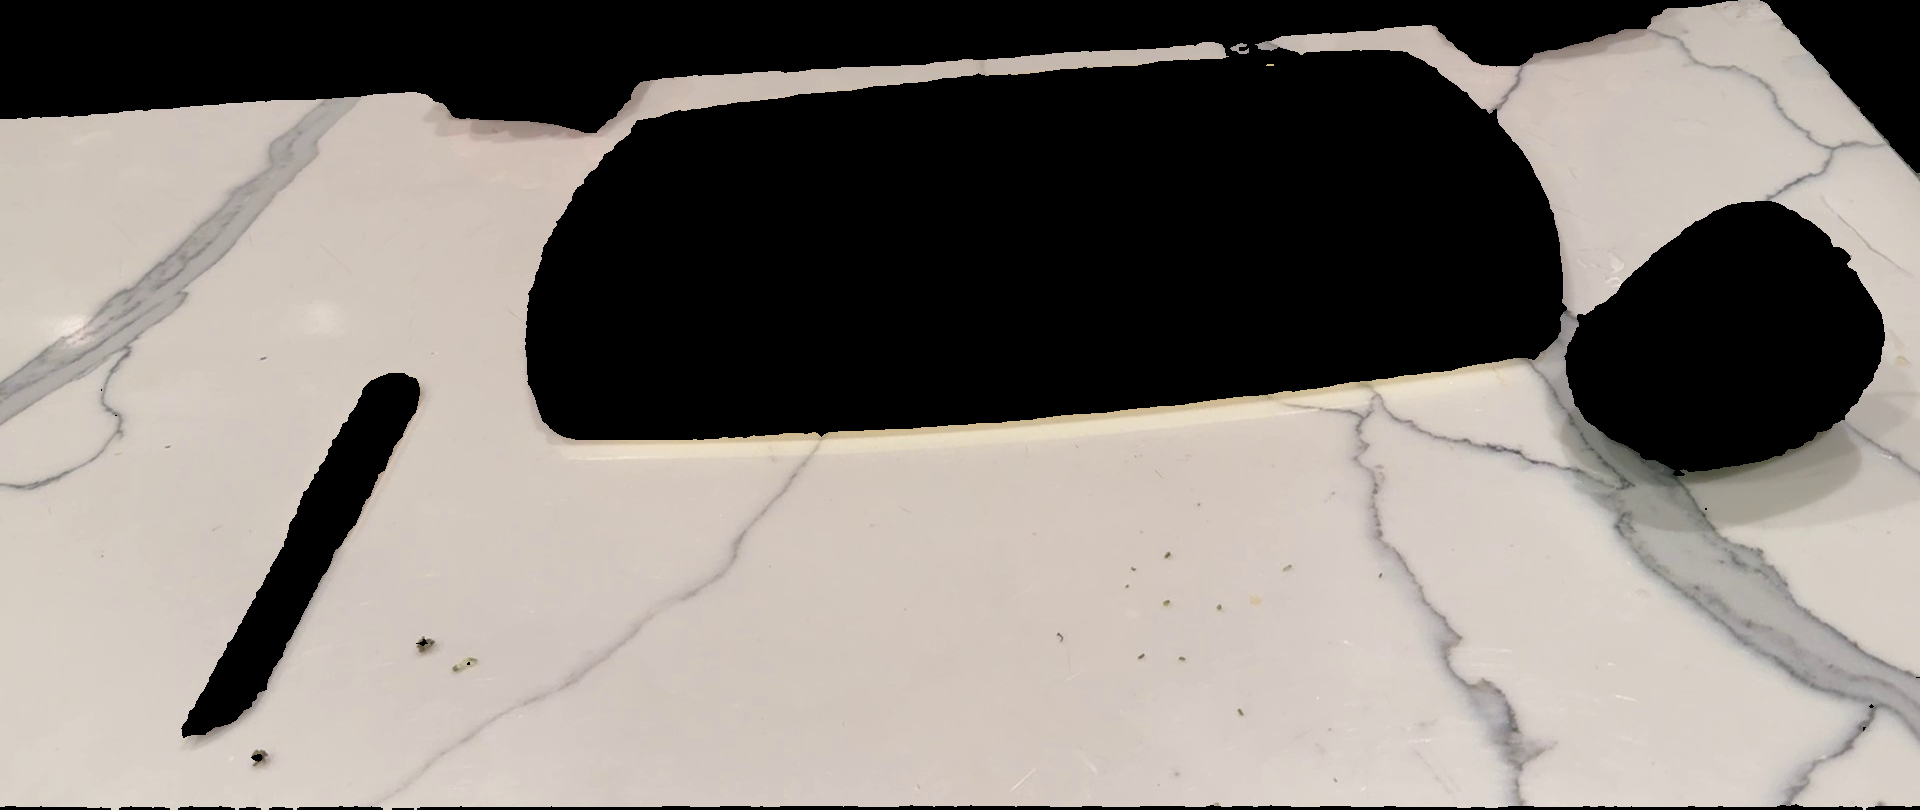

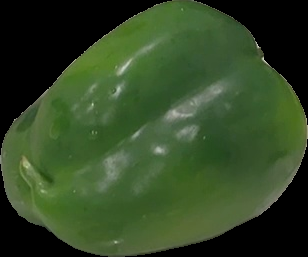

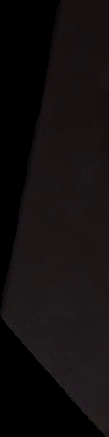

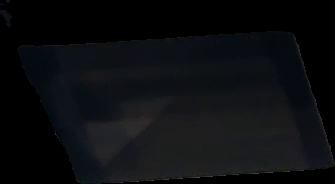

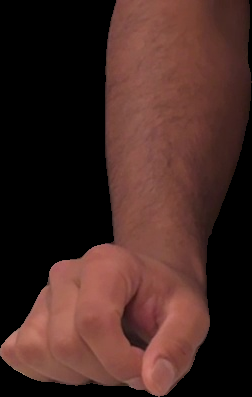

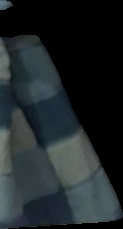

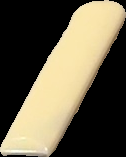

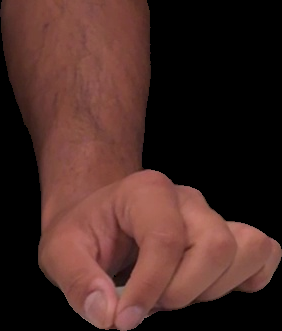

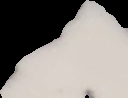

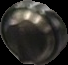

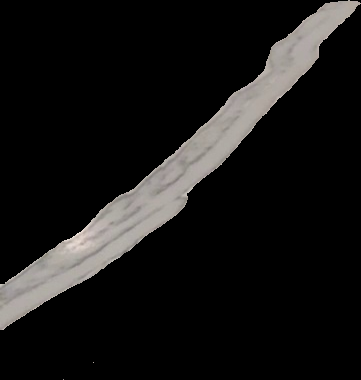

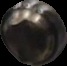

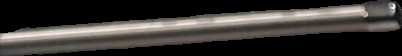

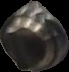

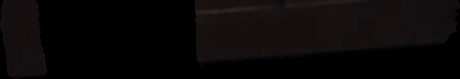

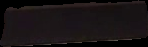

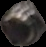

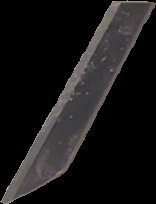

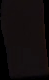

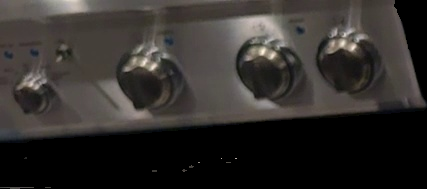

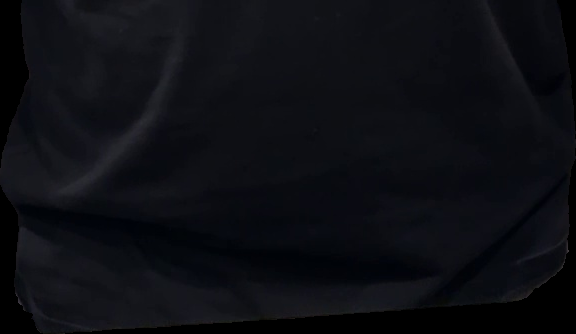

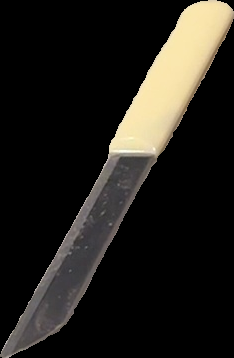

In [29]:
for im in cropped_images2:
    display(im)

In [51]:
sam2, mask_predictor, prompted_predictor = initialize_sam2("cuda")
dinov2 = initialize_dinov2("cuda:0")

Using cache found in /nethome/abati7/.cache/torch/hub/facebookresearch_dinov2_main


In [68]:
from matching import get_mask1_bestmask2

In [73]:
results = get_mask1_bestmask2((dinov2, mask_predictor, prompted_predictor), image_path1, image_path2, pos_points)

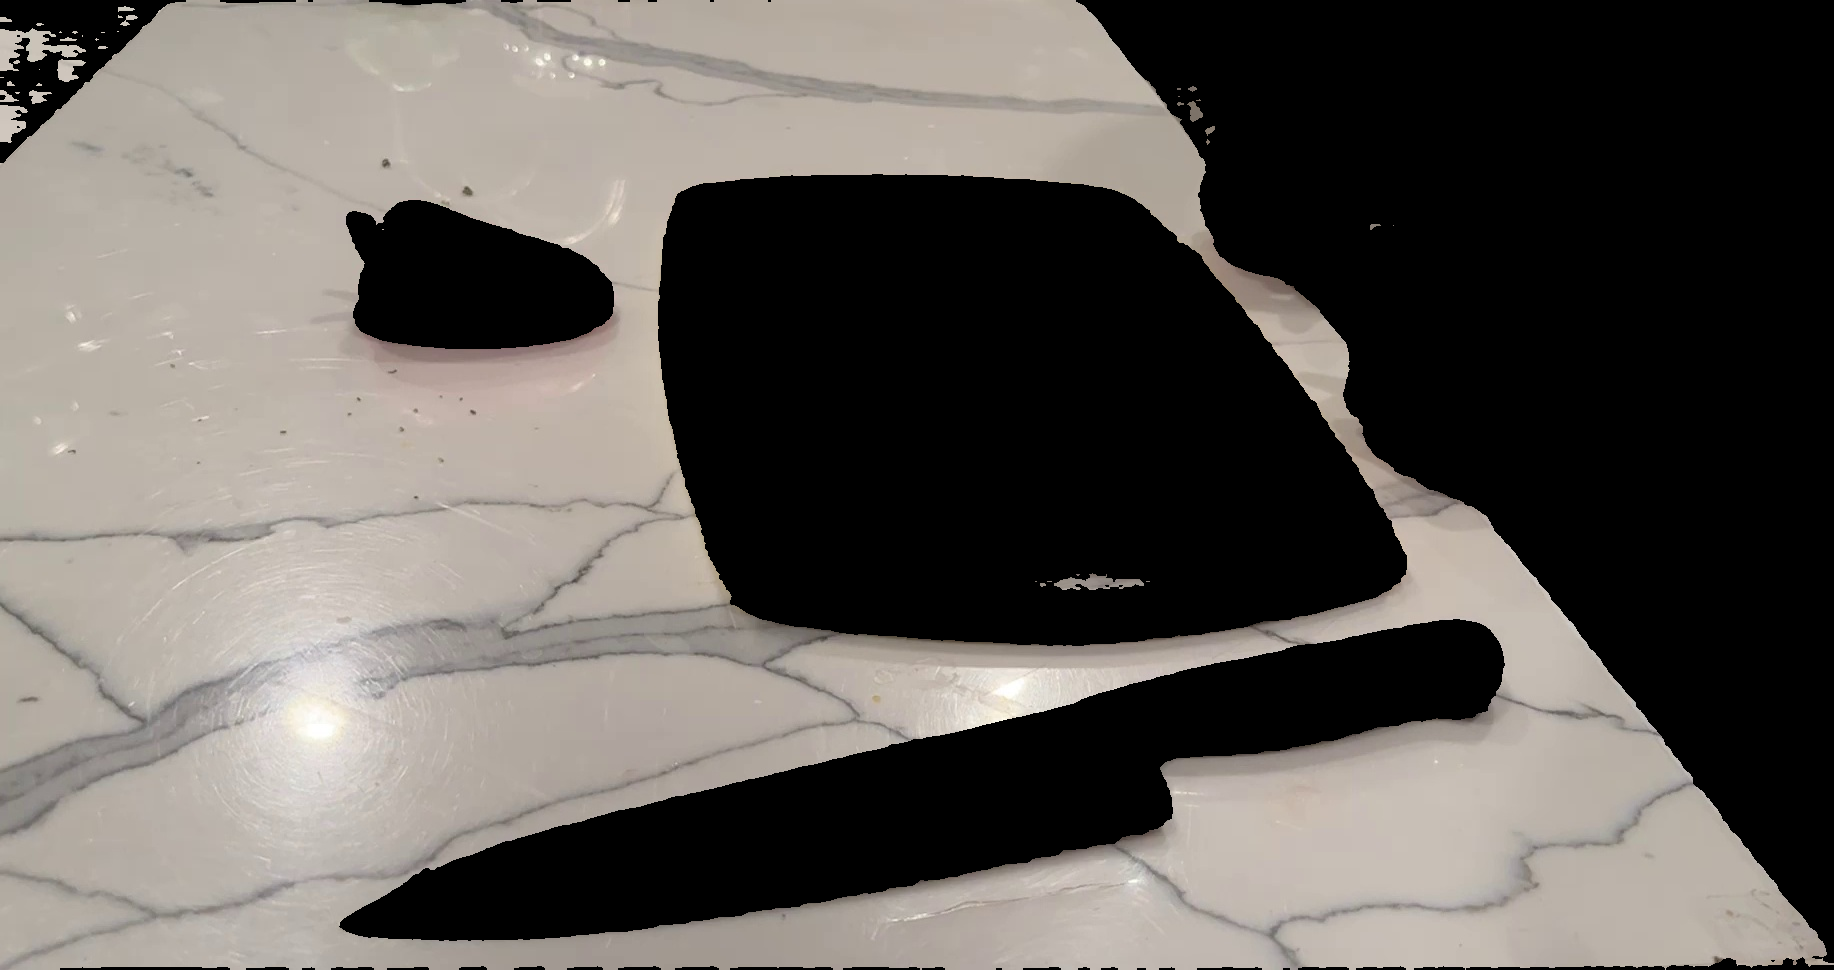

In [74]:
results[0]

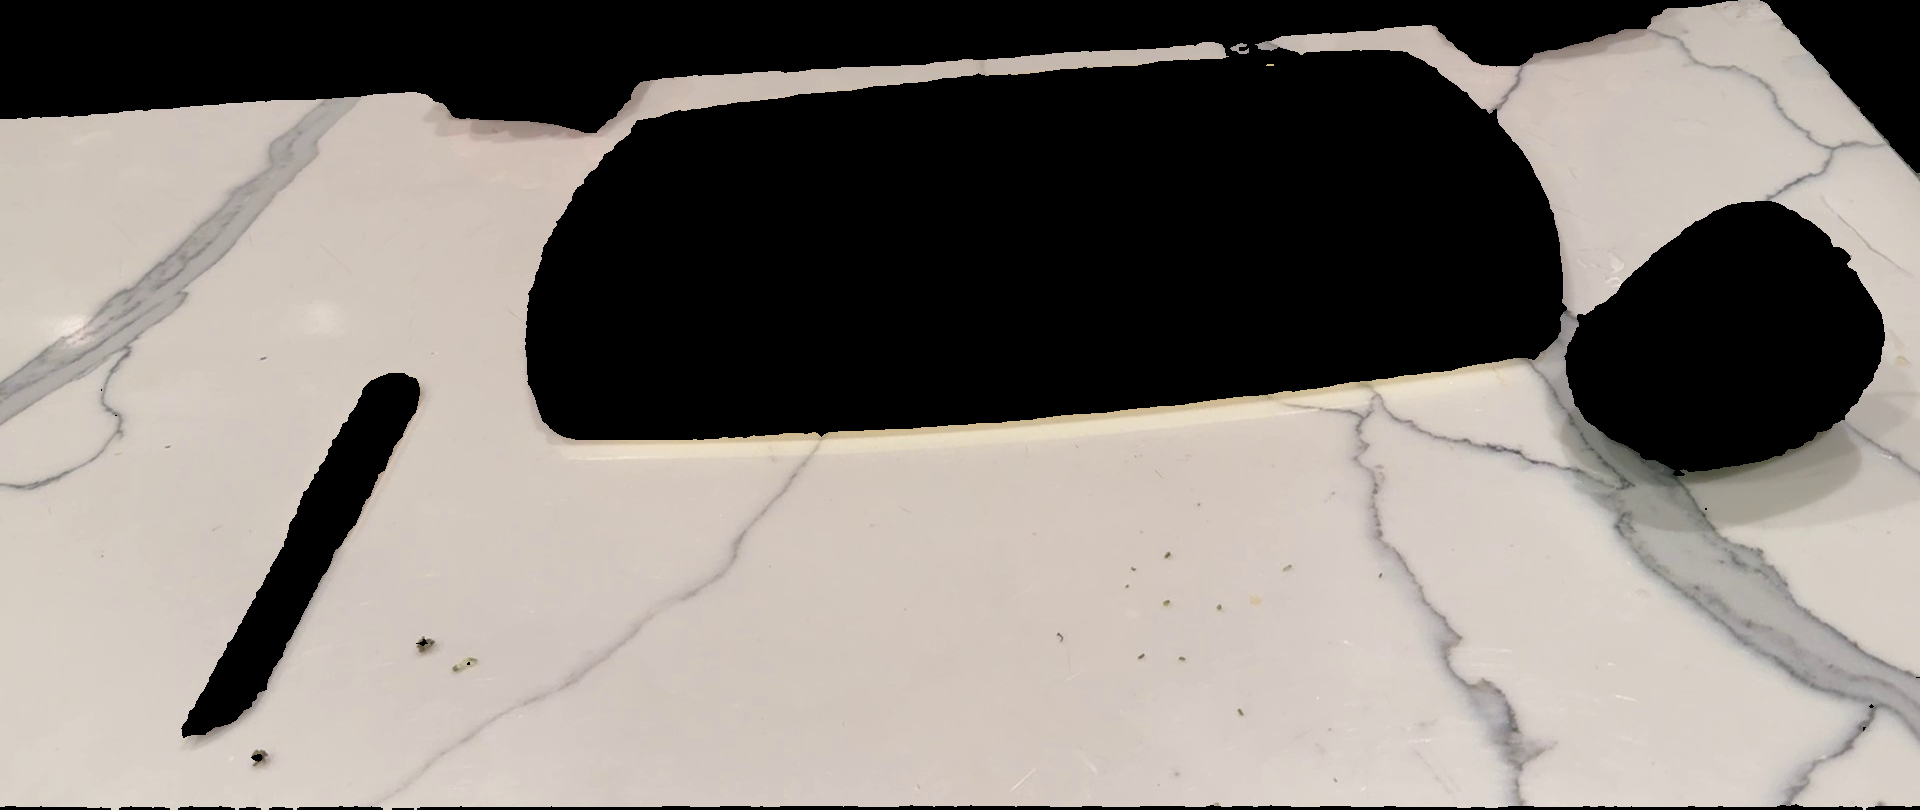

In [75]:
results[1]